In [1]:
from datetime import datetime, date
import os

import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

In [2]:
# dask.config.set({'temporary_directory':'/Users/rwegener/repos/ch'})

client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55633,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:55644,Total threads: 2
Dashboard: http://127.0.0.1:55647/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:55636,


In [4]:
sst_filename = 'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20221231.nc'
geopolar = xr.open_dataset(os.path.join('./data/raw', sst_filename))
geopolar = geopolar.analysed_sst

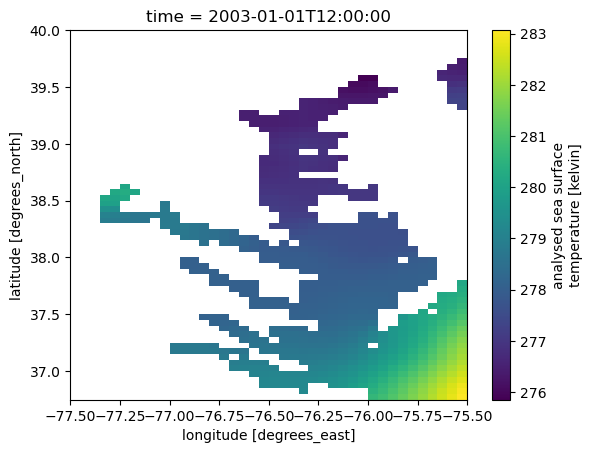

In [5]:
geopolar.isel(time=0).plot()

## Calculate Marine Heatwaves using `marineHeatWaves` Package

### Preprocessing

In [6]:
def format_time(time_np):
    # Format time values
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') 
                    for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list])

In [7]:
time_ordinal = format_time(geopolar.time.values)
sst_np = geopolar.values

In [9]:
sst_np.shape

(7298, 65, 40)

**Nice-to-have** this really shouldn't have to run twice.

### Run the `mhw.detect()` function

In [10]:
%%time

sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

# define a wrapper to rearrange arguments
def func1d(arr, time):
    print('time class and shape', time.__class__, time.shape)
    print('arr class and shape', arr.__class__, arr.shape)

    return mhw.detect(time, arr)

def block_func(block, **kwargs):
    return np.apply_along_axis(func1d, 0, block, **kwargs)

result = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
result = result.compute()

/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/marineHeatWaves/marineHeatWaves.py:283: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/marineHeatWaves/marineHeatWaves.py:283: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/repos/marineHeatWaves/marineHeatWaves.py:283: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN 

time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
arr class and shape <class 'numpy.ndarray'> (7298,)
time class and shape <class 'numpy.ndarray'> (7298,)
ar

The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [13]:
event_statistics = result[0]

In [14]:
event_statistics

array([[{'time_start': [], 'time_end': [], 'time_peak': [], 'date_start': [], 'date_end': [], 'date_peak': [], 'index_start': [], 'index_end': [], 'index_peak': [], 'duration': [], 'duration_moderate': [], 'duration_strong': [], 'duration_severe': [], 'duration_extreme': [], 'intensity_max': [], 'intensity_mean': [], 'intensity_var': [], 'intensity_cumulative': [], 'intensity_max_relThresh': [], 'intensity_mean_relThresh': [], 'intensity_var_relThresh': [], 'intensity_cumulative_relThresh': [], 'intensity_max_abs': [], 'intensity_mean_abs': [], 'intensity_var_abs': [], 'intensity_cumulative_abs': [], 'category': [], 'rate_onset': [], 'rate_decline': [], 'n_events': 0},
        {'time_start': [], 'time_end': [], 'time_peak': [], 'date_start': [], 'date_end': [], 'date_peak': [], 'index_start': [], 'index_end': [], 'index_peak': [], 'duration': [], 'duration_moderate': [], 'duration_strong': [], 'duration_severe': [], 'duration_extreme': [], 'intensity_max': [], 'intensity_mean': [], 'in

In [12]:
import pickle

In [17]:
# with open('./data/interim/event_stats_numpy_dict.pickle', 'wb') as handle:
#     pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Back to regular processing

_Alternate way to improve this workflow: The above computation runs once and gets all the information out of the `mhw.detect()` computation. A second one goes through and does the reformatting for the climatology and threshold._

I think I maybe have to do a loop? `np.vectorize` takes a scalar value but doesn't seem to be able to handle a 2D output, and `np.apply_along_axis` seems to be the opposite.

Progress:
```
def get_climatology(arr):
    return arr['seas']

output = np.vectorize(get_climatology)(result[1])
# or
np.apply_along_axis(get_climatology, 0, result[1])
```

In [11]:
climatology = np.empty(sst_np.shape)
threshold = np.empty(sst_np.shape)

In [12]:
for i in range(result[1].shape[0]):
    for j in range(result[1].shape[1]):
        climatology[:, i, j] = result[1, i, j]['seas']
        threshold[:, i, j] = result[1, i, j]['thresh']

The climatology is repeated for each of the years

### Save Climatology and Threshold

In [13]:
output_dir = './data/interim/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [14]:
# create xarray objects from numpy output of mhw
clim = xr.DataArray(climatology, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using Eric Oliver marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [15]:
clim.to_dataset().to_netcdf(os.path.join(output_dir, 'chesapeake_climatology_geopolar.nc'))

In [16]:
# create xarray objects from numpy output of mhw
thresh = xr.DataArray(threshold, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
thresh = thresh.rename('threshold')

# add array attributes
thresh.attrs['comment'] = '90th percentile treshold values computed using Eric Oliver ' \
    'marineHeatWave package. Uses all defaults from .detect() function - 5 day window' \
    ' half width, 31 day smoothing'
thresh.attrs['source_dataset'] = 'NOAA Geopolar'
thresh.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

# save
thresh.to_dataset().to_netcdf(os.path.join(output_dir, 'chesapeake_threshold_geopolar.nc'))

## Calculate Average Stats by pixel

Define functions for each of the MHW stats aggregations.

In [18]:
def no_occurrences(time_arr):
    '''
    returns the number of MHW events detected over the full time series
    '''
    return len(time_arr['time_start'])

In [19]:
def avg_duration(time_arr):
    '''
    returns the average duration of a MHW event over the full time series
    '''
    return np.mean(time_arr['duration'])

In [20]:
def avg_max_intensity(time_arr):
    '''
    returns the average value for the maximum intensity, `intensity_max`, 
    averaged over the full time series
    '''
    return np.mean(time_arr['intensity_max'])

In [25]:
def avg_mean_intensity(time_arr):
    '''
    returns the average value for the mean intensity, `intensity_mean`, 
    averaged over the full time series
    '''
    return np.mean(time_arr['intensity_mean'])

In [21]:
def avg_no_annual_events(time_arr):
    '''
    counts the number of mhw in each year and returns the average number
    over MHW events per year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2022)))
    for i, yr in enumerate(range(2003, 2022)):
        year_counts[i] = np.count_nonzero(years == yr)
    
    # find the average number of events per year
    return np.mean(year_counts)

In [26]:
def avg_rate_onset(time_arr):
    '''
    returns the rate of onset of MHW, averaged over all MHW in the time 
    series (`rate_onset`)
    '''
    return np.mean(time_arr['rate_onset'])

In [27]:
def avg_rate_decline(time_arr):
    '''
    returns the rate of decline of MHW, averaged over all MHW in the time series 
    (`rate_decline`)
    '''
    return np.mean(time_arr['rate_decline'])

In [28]:
def avg_cum_intensity(time_arr):
    '''
    calculate the cumulative intensity in each year and returns the average over
    all the years
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # create a pandas dataframe to zip the years and the cumultive intensities
    df = pd.DataFrame({'year': years, 
                       'cumulative_intensity': time_arr['intensity_cumulative']})
    # groupby to take the mean of each year
    df = df.groupby('year').mean()
    # reindex to make sure that years without marine heatwaves are still present
    df = df.reindex(range(2003, 2022), fill_value=0)
    
    # find the average number of events per year
    return df['cumulative_intensity'].mean()

Run the functions on each of the pixels in the dataset

In [29]:
def apply_function(function, mhw_event_statistics, matching_arr):
    """
    Apply the given function in a vectorized manner (over all the pixels)
    to the MHW event data from mhw.detect(). Reformat and output as a
    dataarray.
    :function: a function which takes a 1D array that is to be applied to all
    the pixels
    :avg_stats_arr: the 0th output of the mhw.detect() function, in an array
    form for all of the pixels
    :matching_arr: a dataarray with lat and lon that has coordinate dimensions
    that matching the pixel locations of avg_stats_arr
    """
    stats_output = np.vectorize(function)(mhw_event_statistics)
    return xr.DataArray(stats_output, 
                          coords=[matching_arr.lat.values, 
                                  matching_arr.lon.values], 
                          dims=['latitude', 'longitude'])

In [30]:
no_occ_da = apply_function(no_occurrences, event_statstics, geopolar)
avg_dur_da = apply_function(avg_duration, event_statstics, geopolar)
avg_max_int_da = apply_function(avg_max_intensity, event_statstics, geopolar)
avg_mean_int_da = apply_function(avg_mean_intensity, event_statstics, geopolar)

avg_rate_on_da = apply_function(avg_rate_onset, event_statstics, geopolar)
avg_rate_off_da = apply_function(avg_rate_decline, event_statstics, geopolar)

avg_annual_events_da = apply_function(avg_no_annual_events, event_statstics, geopolar)
avg_cum_intensity_da = apply_function(avg_cum_intensity, event_statstics, geopolar)

/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_duration (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in avg_max_intensity (vectorized)
  outputs = ufunc(*inputs)
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encoun

## Save each statistic into individual netcdf files

In [31]:
output_dir = './data/processed/mhw_stats_outputs/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Creating a land mask

In [32]:
mask = geopolar.isel(time=0).drop('time').rename(
    {'lat': 'latitude', 'lon': 'longitude'}
)

Number of Occurrences

In [39]:
# mask out land
no_occ_da = no_occ_da.where(~mask.isnull())

# Add metadata
no_occ_da = no_occ_da.rename('total_no_occurrences').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of MHW', 'description': 
     "The total number of MHWs reported from EJO's MHW code for each pixel. " \
     "Passing along EJO's `n_events` metric.", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
no_occ_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'no_occurrences_CBay_geopolar.nc')
)

Average Duration

In [40]:
# Add metadata
avg_dur_da = avg_dur_da.rename('avg_duration').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# of days', 'description': "The 'duration' " \
     "statistic reported from EJO's MHW code for each pixel, averaged over all of " \
     "the MHW identified in that pixel", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')
    }
)

# Save
avg_dur_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_mhw_duration_CBay_geopolar.nc')
)

Average Max Intensity

In [41]:
# Add metadata
avg_max_int_da = avg_max_int_da.rename('avg_max_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the maximum intensity, " \
     "`intensity_max`, averaged over the full time series", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_max_int_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_max_intensity_CBay_geopolar.nc')
)

Average Mean Intensity

In [36]:
# Add metadata
avg_mean_int_da = avg_mean_int_da.rename('avg_mean_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C', 
     'description': "returns the average value for the mean intensity, " \
     "`intensity_mean`, averaged over the full time series", 'processing_date': 
     datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_mean_int_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_mean_intensity_CBay_geopolar.nc')
)

Average rate of onset

In [42]:
# Add metadata
avg_rate_on_da = avg_rate_on_da.rename('avg_onset_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
     "the rate of onset of MHW, averaged over all MHW in the time series " \
     "(`rate_onset`)", 'processing_date':  datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_rate_on_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_rate_onset_CBay_geopolar.nc')
)

Average rate of decline

In [43]:
# Add metadata
avg_rate_off_da = avg_rate_off_da.rename('avg_decline_rate').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C / day', 'description': "returns " \
    "the rate of deline of MHW, averaged over all MHW in the time series " \
    "(`rate_decline`)", 'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_rate_off_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_rate_decline_CBay_geopolar.nc')
)

Average number of annual events

In [46]:
# Mask land
avg_annual_events_da = avg_annual_events_da.where(~mask.isnull())

# Add metadata
avg_annual_events_da = avg_annual_events_da.rename('avg_no_annual_events').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': '# MHW', 'description': "counts the number " \
     "of mhw in each year and returns the average number of MHW events per year", 
     'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_annual_events_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_no_annual_events_CBay_geopolar.nc')
)

Average cumulative intensity

In [35]:
# Mask land
avg_cum_intensity_da = avg_cum_intensity_da.where(~mask.isnull())

# Add metadata
avg_cum_intensity_da = avg_cum_intensity_da.rename('avg_cum_intensity').assign_attrs(
    {'source': 'NOAA Geopolar', 'unit': 'deg C * day', 'description': "calculate the " \
     "cumulative intensity of all the mhw for each year and returns the average over " \
     "all the years", 'processing_date': datetime.strftime(date.today(), '%Y-%m-%d')}
)

# Save
avg_cum_intensity_da.to_dataset().to_netcdf(
    os.path.join(output_dir, 'average_cum_intensity_CBay_geopolar.nc')
)